## Abstract :

We know that the K nearest neighbor algorithm has hyper-parameter in addition to k. We are using the titanic dataset over here and are implementing the KNN (k nearest neighbors) algorithm and are simultaneously tuning more than one hyper-parameters by using the nested for loop function.

## Disadvantages of kNN algorithm is as follows:

1. K-NN slow algorithm: K-NN might be very easy to implement but as dataset grows efficiency or speed of algorithm declines very fast.

2. Curse of Dimensionality: KNN works well with small number of input variables but as the numbers of variables grow K-NN algorithm struggles to predict the output of new data point.

3. K-NN needs homogeneous features: If you decide to build k-NN using a common distance, like Euclidean or Manhattan distances, it is completely necessary that features have the same scale, since absolute differences in features weight the same, i.e., a given distance in feature 1 must means the same for feature 2.

3. Optimal number of neighbors: One of the biggest issues with K-NN is to choose the optimal number of neighbors to be consider while classifying the new data entry.

4. Imbalanced data causes problems: k-NN doesn’t perform well on imbalanced data. If we consider two classes, A and B, and the majority of the training data is labeled as A, then the model will ultimately give a lot of preference to A. This might result in getting the less common class B wrongly classified.

5. Outlier sensitivity: K-NN algorithm is very sensitive to outliers as it simply chose the neighbors based on distance criteria.

6. Missing Value treatment: K-NN inherently has no capability of dealing with missing value problem.

## About the dataset "Titanic Dataset"

Choosing the Titanic dataset.

It's description is as follows :

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [3]:
#importing all the libraries

import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sns

import joblib

%matplotlib inline

#### Since the joblib library is not present for this version of python as well for mac,hence installing the joblib library.

In [4]:
!pip install joblib

In [5]:
#importing the Titanic dataset and checking the shape and header of the data

my_df = pd.read_csv("Titanic_full.csv")
print(my_df.shape)
my_df.head(10)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


#### Considering "Survived" as the target variable

## Train - Valid- Test Split

In [6]:
#Calculate 15% of 1309. This is about 209 rows of data.
#So, 1309-209 = 1100 rows of data will remain for the
#train and valid sets which we will seperate later. 200 rows of data
#go as test set data

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1100)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(1100, 12) (209, 12)


## Data Pre-processing

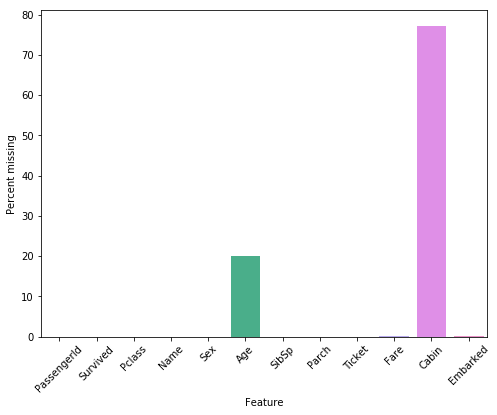

In [7]:
#Checking the null values and eliminating them

null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

#### From the above plot, it looks like Cabin has ~80%missing values.
It would be meaningless to impute or fill in 80% values, so we drop the column.
We will impute age (which has ~ 20% missing, but we'll try to impute),
Fare, and Embarked column.These have very little missing values

We are going to preprocess this dataset in these steps--

1. Convert the entire dataframe to an array of numbers. This itself is going to happen in two steps -- (a) Convert object types and string types to category type (b) map and convert cateogries of numbers.

2. Impute or "fill in" missing values or NaNs. Here, continuous (e.g. Fare column) and categorical values are treated separately. For filling up missing continuous values, we use the median value of that column, and filling up missing categorical values, we use 0. Also, we add a separate "marker" column for both that notes whether a value has been imputed or not.

3. Finally, for a lot of the algorithms like k-NN, we scale the data to lie between 0 and 1 with mean zero and unit variance.

In [8]:
mydf_train_valid_2 = mydf_train_valid.drop("Cabin",axis = 1)
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(2)

(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [9]:
#Check types of each column with the dataframe info () method
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null object
Sex            1100 non-null object
Age            881 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null object
Fare           1099 non-null float64
Embarked       1098 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 94.6+ KB


In [10]:
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [11]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
print()

In [12]:
#Check dtypes of columns after this operation
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null category
Sex            1100 non-null category
Age            881 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null category
Fare           1099 non-null float64
Embarked       1098 non-null category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [13]:
'''Check the cateogry mapping for Embarked and Sex column. We need this
later'''
print(mydf_train_valid_3.Embarked.cat.categories)
print(mydf_train_valid_3.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


All object categories like Name, Sex, and Ticket have been converted to
Category dtype !

In [14]:
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [15]:
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)

In [16]:
mydf_train_valid_4.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False
2,3,1,3,442,1,26.0,0,0,799,7.9250,3,False,False


In [17]:
'''Please store the null_table, category mapping separately.
We will need to process the test dataset using these values'''
my_table

{'Age': 28.0, 'Fare': 14.4583}

In [18]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y = mydf_train_valid_4["Survived"]
X = mydf_train_valid_4.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1100, 12) (1100,)


In [19]:
#Scaling the continous variables
X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con = X.drop(X_cat,axis = 1)
print(X_cat.shape,X_con.shape)

(1100, 10) (1100, 2)


In [20]:
scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [21]:
'''Store this scaler variable or its mean and SD, by pickling or something;
we need to use the same mean and SD scaler later while pre-processing 
the test set. Now, let's join the cateogrical and scaled continuous 
variables, back together into one dataframe'''

df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [22]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''

X_train,X_valid = mydf_splitter(X_full,900)
Y_train,Y_valid = mydf_splitter(Y,900)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)

(900, 12) (200, 12) (900,) (200,)


In [23]:
'''Time for training the model and evaluating it on the validation set. 
At first, let's use the default values for the kNN hyperparameters -
n_neighbors = 3,weights = 'uniform'). KNN has more hyperparameters such as
leaf_size, metric, etc. But, these two are key hyperparamters'''

my_knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)

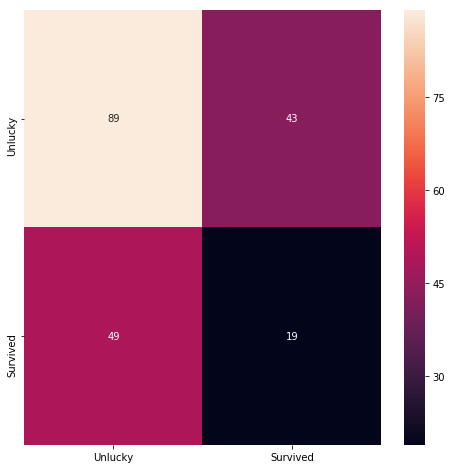

In [24]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize = (8,8))
sns.heatmap(my_knn_df, xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

In [25]:
print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))

#An MCC of -0.0474 looks bad !We need to do model tuning or 
#hyperparameter tuning to try to make it better

0.54 -0.0474697036788388 0.29230769230769227


## Feature engineering :¶

Feature engineering, also known as feature creation, is the process of constructing new features from existing data to train a machine learning model. This step can be more important than the actual model used because a machine learning algorithm only learns from the data we give it, and creating features that are relevant to a task is absolutely crucial

#### Fare
Fare feature is positively skewed and survival rate is extremely high on the right end. 13 quantile based bins are used for Fare feature. Even though the bins are too much, they provide decent amount of information gain. The groups at the left side of the graph has the lowest survival rate and the groups at the right side of the graph has the highest survival rate. This high survival rate was not visible in the distribution graph. There is also an unusual group (15.742, 23.25] in the middle with high survival rate that is captured in this process.

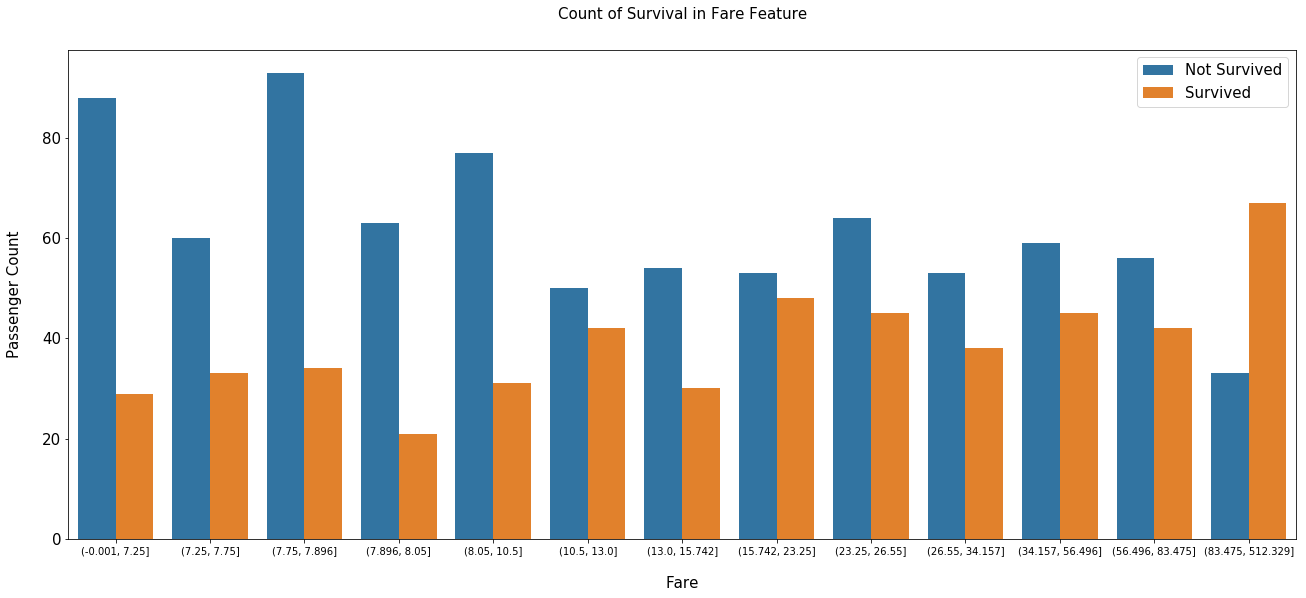

In [26]:
import pandas as pd
my_df['Fare'] = pd.qcut(my_df['Fare'], 13)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=my_df)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()



#### Age
Age feature has a normal distribution with some spikes and bumps.

10 quantile based bins are used for Age feature.

The first bin has the highest survival rate and 4th bin has the lowest survival rate.

Those were the biggest spikes in the distribution.

There is also an unusual group (34.0, 40.0] with high survival rate that is captured in this process.

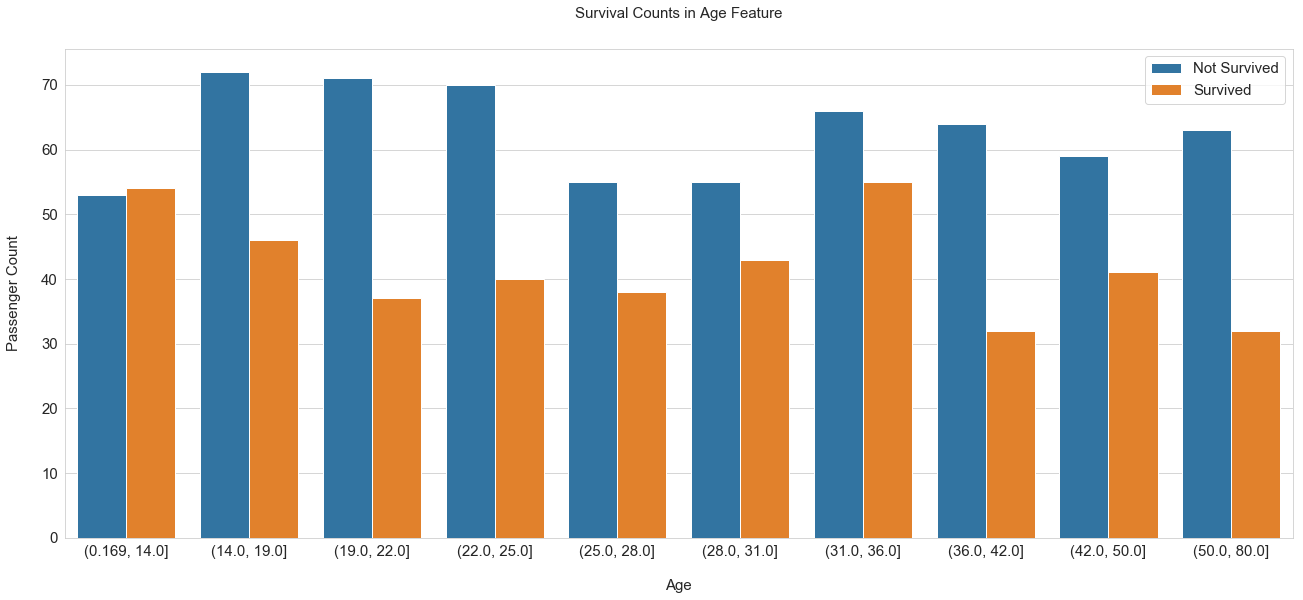

In [55]:
my_df['Age'] = pd.qcut(my_df['Age'], 10)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=my_df)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

#### Family Size & Ticket Frequency
Family_Size is created by adding SibSp, Parch and 1. SibSp is the count of siblings and spouse, and Parch is the count of parents and children. Those columns are added to find the total size of families. Adding 1 at the end, is the current passenger. Graphs have clearly shown that family size is a predictor of survival because different values have different survival rates. Family Size with 1 are labeled as Alone. Family Size with 2, 3 and 4 are labeled as Small. Family Size with 5 and 6 are labeled as Medium. Family Size with 7, 8 and 11 are labeled as Large.

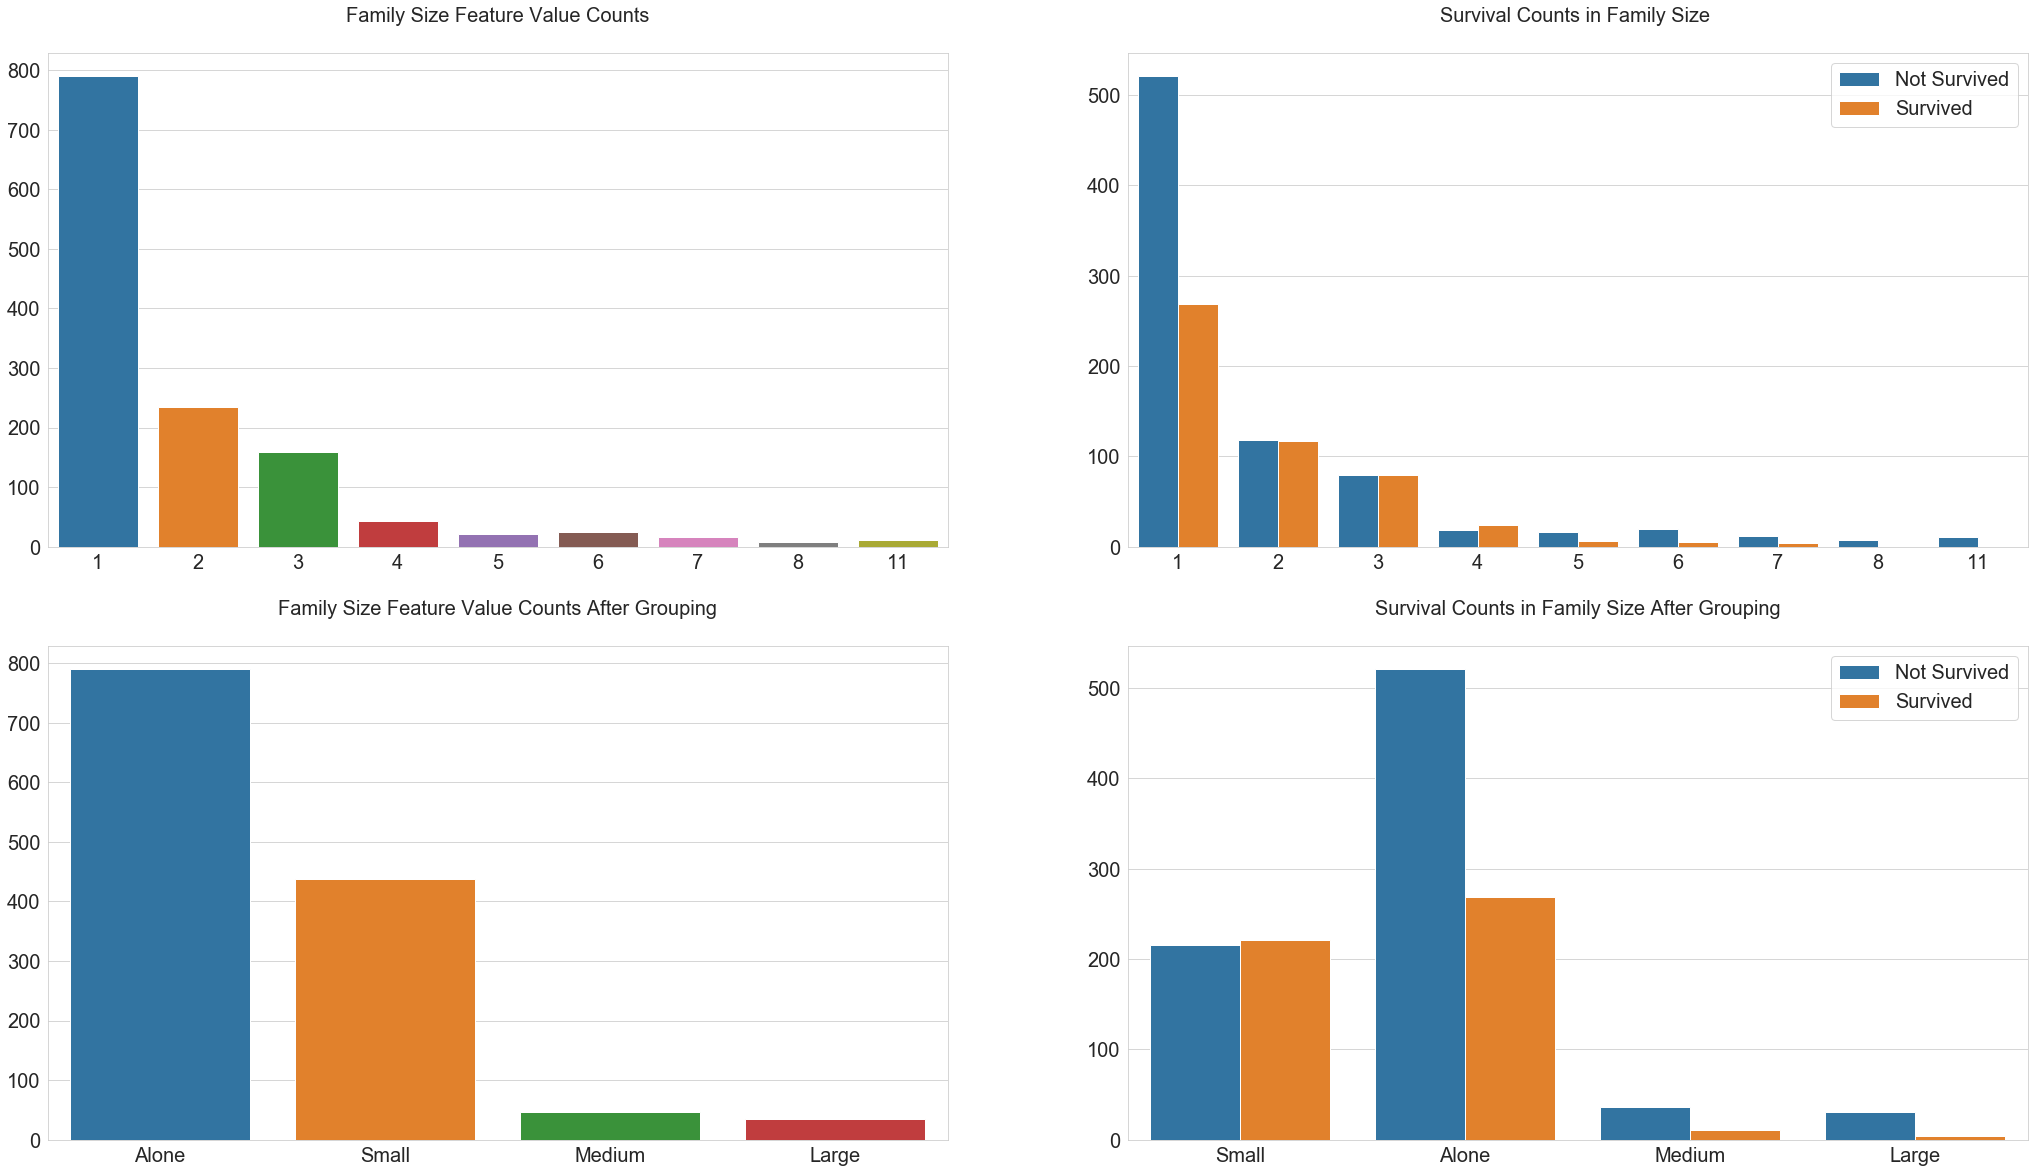

In [56]:
my_df['Family_Size'] = my_df['SibSp'] + my_df['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=my_df['Family_Size'].value_counts().index, y=my_df['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=my_df, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
my_df['Family_Size_Grouped'] = my_df['Family_Size'].map(family_map)

sns.barplot(x=my_df['Family_Size_Grouped'].value_counts().index, y=my_df['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=my_df, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

. There are too many unique Ticket values to analyze, so grouping them up by their frequencies makes things easier.

. How is this feature different than Family_Size? Many passengers travelled along with groups. Those groups consist of friends, nannies, maids and etc. They weren't counted as family, but they used the same ticket.

. Why not grouping tickets by their prefixes? If prefixes in Ticket feature has any meaning, then they are already captured in Pclass or Embarked features because that could be the only logical information that can be derived from the Ticket feature.

. According to the graph, groups with 2,3 and 4 members had a higher survival rate. Passengers who travel alone has the lowest survival rate. After 4 group members, the survival rate decreases drastically. This pattern is very similar to Family_Size feature, but there are small differences.

.Ticket_Frequency values are not grouped like Family_Size because that would basically create the same feature with perfect correlation. This kind of feature wouldn't provide any information gain.

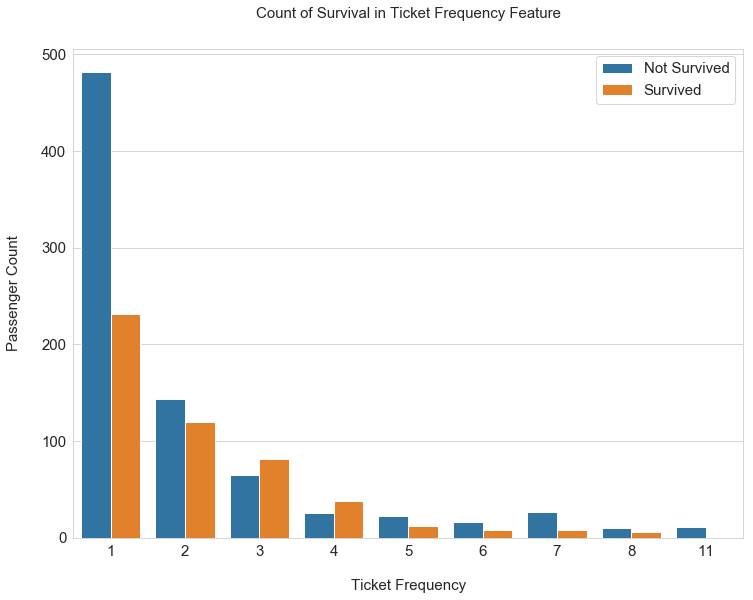

In [57]:
my_df['Ticket_Frequency'] = my_df.groupby('Ticket')['Ticket'].transform('count')

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=my_df)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

#### Conclusion of feature engineering
. Age and Fare features are binned. . Binning helped dealing with outliers and it revealed some homogeneous groups in those features. . Family_Size is created by adding Parch and SibSp features and 1. . Ticket_Frequency is created by counting the occurence of Ticket values.

## Hyperparameter tuning

In [27]:
# We chose a value of K = 5 here. But how do we know if that's the right 
# value? We need to do hyper parameter tuning.That is, we need to check 
# different values of K and find out performance scores for each on the 
# validation set! We will pick the value of K that gives the best 
# validation set accuracy and use that value of K to predict on the
# test set, which we have kept aside

from sklearn.metrics import accuracy_score





num_neighs = list()
accuracy_list = list()
num_p = list()
accuracy_list_p = list()







for neighbor in range(1,20):
    my_knn_model = KNeighborsClassifier(n_neighbors = neighbor,weights = 'uniform')
    my_knn_model = KNeighborsClassifier()
    my_knn_model.fit(X_train,Y_train)
    Y_pred = my_knn_model.predict(X_valid)
    accuracy = accuracy_score(Y_valid,Y_pred)
   
    for power_param in range(1,3):
        my_knn_model1 = KNeighborsClassifier(n_neighbors = neighbor,weights = 'uniform',p = power_param)
        my_knn_model1.fit(X_train,Y_train)
        Y_pred = my_knn_model.predict(X_valid)
        accuracy1 = accuracy_score(Y_valid,Y_pred)
        num_p.append(power_param)
        num_neighs.append(neighbor)
        accuracy_list.append(accuracy)



In [28]:
eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": accuracy_list , "Power parameter value" : num_p})
eval_df

,Num of neighbors,Valid accuracy Score,Power parameter value
0,1,0.54,1
1,1,0.54,2
2,2,0.54,1
3,2,0.54,2
4,3,0.54,1
5,3,0.54,2
6,4,0.54,1
7,4,0.54,2
8,5,0.54,1
9,5,0.54,2


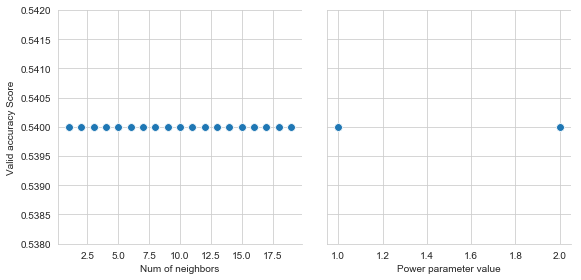

In [29]:
#Plot accuracy Vs validation set accuracy of the model
sns.set_style("whitegrid")
sns.pairplot(eval_df,x_vars = ("Num of neighbors","Power parameter value"),
             y_vars = "Valid accuracy Score",plot_kws = {'s': 60},height = 4.0)

To know the path of the where my jupyter notebook has been saved.

In [30]:
import os
os.getcwd()

'/Users/lsrajput/Downloads'

In [31]:
mypath = '/Users/lsrajput/Downloads'

In [32]:
#Every value of K and p seems to give the best validation set accuracy (= 0.54) ! So, let's turn to the test set
#and use K = 1 and p = 1 for that !OK, so how do we save this trained and 
#hyperparameter tuned model for later use? First, we club together, the
#train and valid set. We already have this dataframe. Then, we make and 
#train a model with K = 1 and p=1. Then save it with joblib, which we imported 
#earlier'''


knn_model_fin = KNeighborsClassifier(n_neighbors = 1,weights = 'uniform',p = 1)
knn_model_fin.fit(X_full,Y)

!mkdir knn_model
knn_model_name = f'{mypath}/knn_model/knn_model_final.sav'
joblib.dump(knn_model_fin,knn_model_name)

mkdir: knn_model: File exists


['/Users/lsrajput/Downloads/knn_model/knn_model_final.sav']

In [33]:
#Make sure your model has been saved !
!ls knn_model

knn_model_final.sav


In [34]:
# Congrats! You have saved your model!Now, let's read it back in!
knn_model_loaded = joblib.load(knn_model_name)

## Evaluating test set accuracy with the trained model

In [35]:
'''Before we can apply this on the test set, we
need to pre-process the test set in exactly the same way we did the
train_valid set !!!'''

print(mydf_test.shape)
mydf_test.head(3)

(209, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,NaN,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,NaN,S


In [36]:
#get rid of the "cabin" column as we did before with the train_valid set
mydf_test1 = mydf_test.drop("Cabin",axis = 1)
print(mydf_test1.shape)
mydf_test1.head(3)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,S


In [37]:
'''Make sure the category codes for train and test sets are the same as 
the ones we used previously! Here, we have coded, Name, Sex, Ticket and 
embarked. Because Name and Ticket ids will not be repeated, 
we will check Sex and embarked. Checking category codes for the test set...'''

mydf_test2 = str_to_cat(mydf_test1)
mydf_test2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [38]:
#Check for the Embarked column
mydf_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [39]:
#Cool, this means the category codes are the same. We can proceed.
#Make sure you use the same impute values of median.
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,
                                         null_table = my_table)
print(mydf_test3.shape)
mydf_test3.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
1100,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1101,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
1102,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [40]:
my_table1

{'Age': 28.0, 'Fare': 14.4583}

In [41]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!


Y_t = mydf_test3["Survived"]
X_t = mydf_test3.drop(["Survived"],axis = 1)

print(X_t.shape,Y_t.shape)

(209, 12) (209,)


In [42]:
#Separate continuous and categorical variables/columns for scaling

X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con_t = X_t.drop(X_cat_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(209, 10) (209, 2)


In [43]:
'''Scale using the training set mean and SD. This is already captured in
the scaler object we made. Else, save that in a joblib dump too to reload'''

X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape)
X_con_sct.head(2)



(209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [44]:
print(X_cat_t.shape,X_con_sct.shape)

(209, 10) (209, 2)


In [45]:
#Re-index before merging
X_cat_t.reset_index(inplace = True,drop = False)

In [46]:
X_cat_t.head()

,index,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1100,1101,3,47,2,0,0,106,3,False,False
1,1101,1102,3,6,2,0,0,146,3,False,False
2,1102,1103,3,62,2,0,0,187,3,True,False
3,1103,1104,2,45,2,0,0,179,3,False,False
4,1104,1105,2,91,1,1,0,38,3,False,False


In [47]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1101,3,47,2,0,0,106,3,False,False
1,1102,3,6,2,0,0,146,3,False,False


In [48]:
#Merge the two sets of columns
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(209, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


In [49]:
#Now we are ready to test it out. Let's load the saved model first.
kNN_loaded = joblib.load(f'{mypath}/knn_model/knn_model_final.sav')

In [50]:
#Testing...
Y_test_pred = kNN_loaded.predict(X_test_I)

In [51]:
print(accuracy_score(Y_t,Y_test_pred),
      matthews_corrcoef(Y_t,Y_test_pred),f1_score(Y_t,Y_test_pred))

0.5789473684210527 0.12224161765763172 0.44999999999999996


In [52]:
'''We are done! Our kNN model is not doing great on this dataset but
we learnt how to properly use machine learning.'''

'We are done! Our kNN model is not doing great on this dataset but\nwe learnt how to properly use machine learning.'

In [53]:
'''Write out full train_valid and test dataframes for later use
in module III'''
X_full["Survived"] = Y
X_test_I["Survived"] = Y_t

print(X_full.shape)
print(X_test_I.shape)

(1100, 13)
(209, 13)


## Conclusion :

By using the kNN algorithm, we found the accuracy of the model which was 0.54 intially. Now we chose a set of optimal hyperparameters for a learning algorithm in order to do hyperparameter tuning. Choosing n_neighbors and p as the hyperparameters whose values we iterated in order to get the best accuracy model, got constant values of accuracy throughout the values of n_neighbors(k values) as well as the p hyperparameter values. After evaluating the test set accuracy with the trained set, one can say that the kNN model is not doing that great as the final accuracy remains only 0.5789. 



## Contribution :

Code by self ---- 50%

Code referred ---- 50%

## Citations :

https://stackoverflow.com/questions/10238770/indentationerror-expected-an-indented-block - Stack overflow. To remove the indentation error

https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624 - To understand the concept of hyperparameter tuning.

https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/ - To understand the concept of kNN algorithm

https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ - To understand how to install the joblib library



## License


Copyright 2019 Ria Rajput

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.